<a href="https://colab.research.google.com/github/OlimpiaGarcia/Statistics_dcc/blob/main/Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import pandas as pd
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, precision_score, cohen_kappa_score
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp

# Read CSV

In [2]:
data = pd.read_csv("/content/ObesityDataSet_raw_and_data_sinthetic.csv")
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


<Axes: >

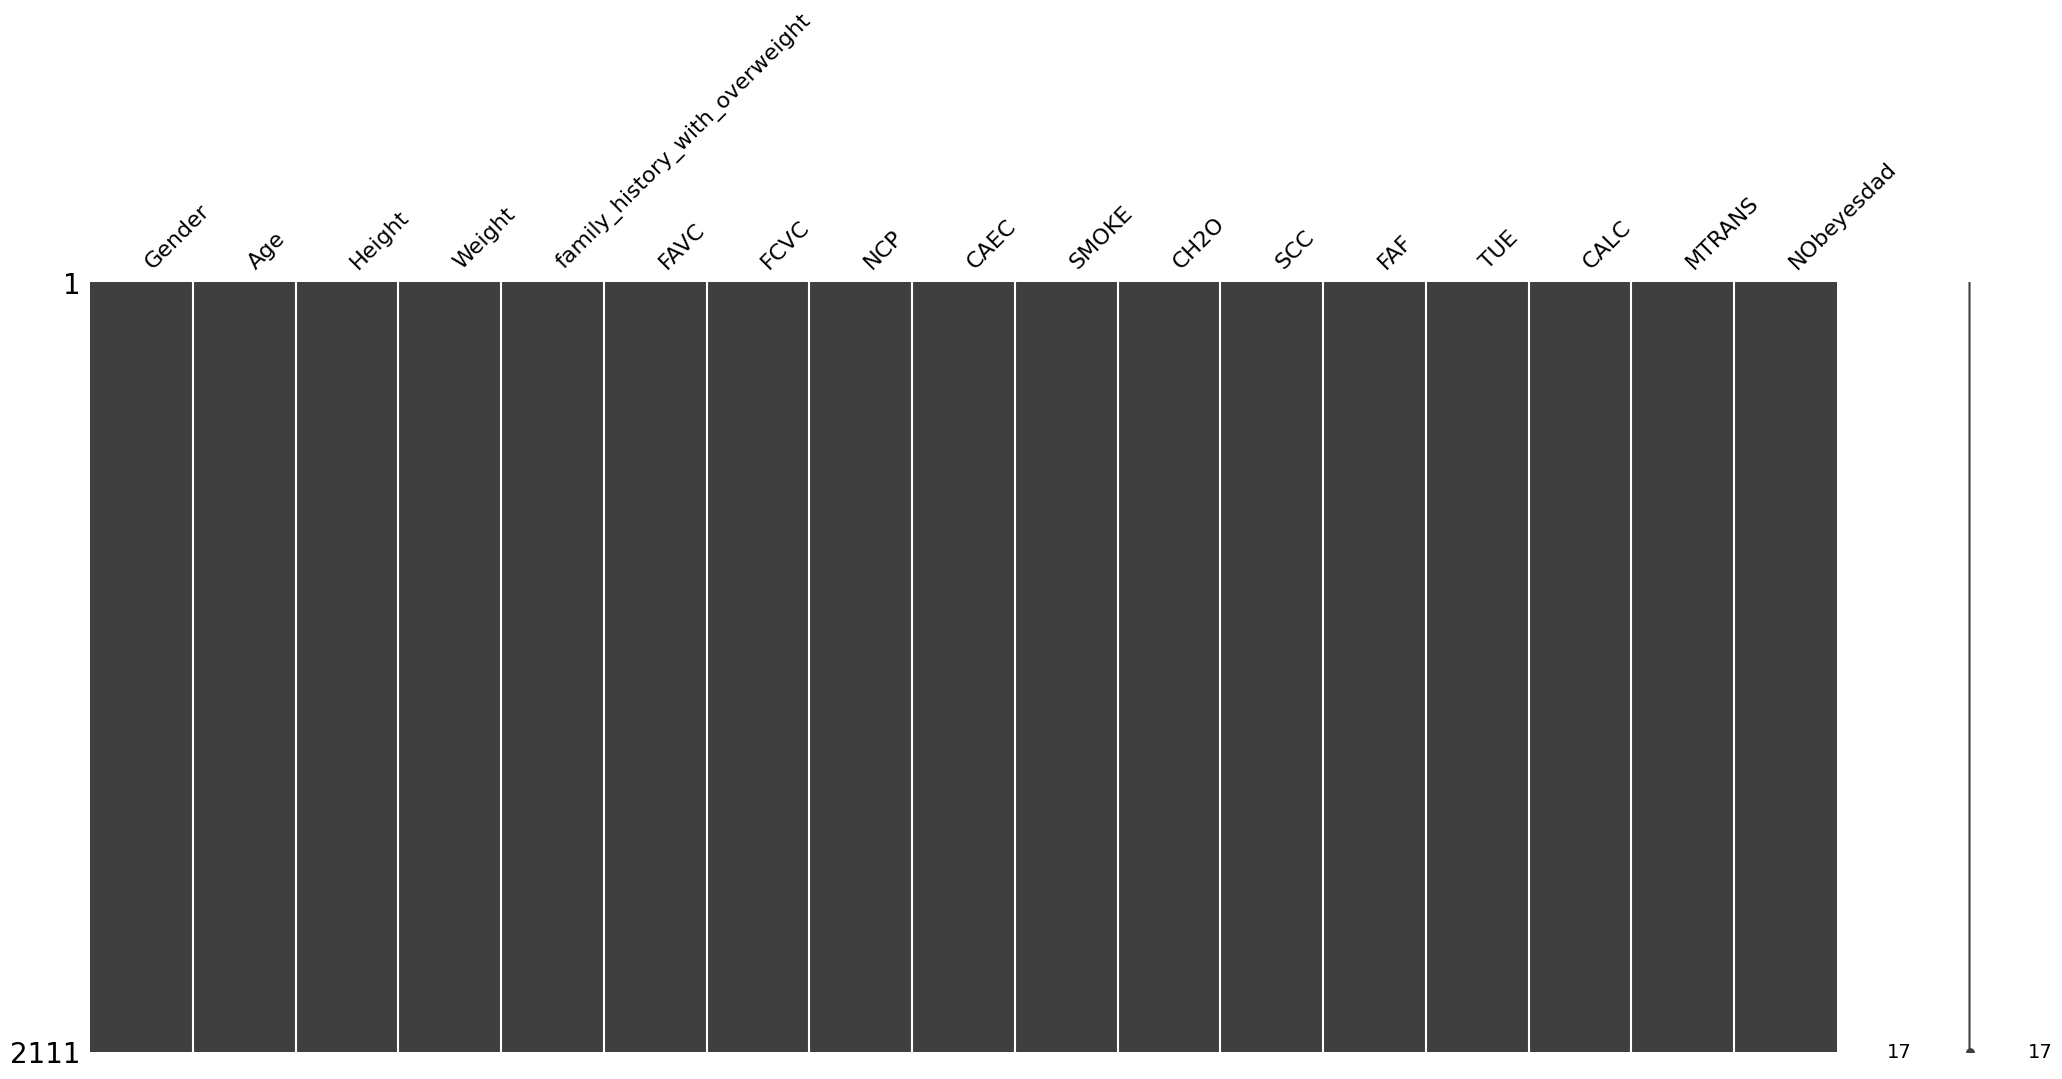

In [3]:
missingno.matrix(data)

## Recode the NObeyesdad obesity levels into exactly four categories for all analyses:
1. Insufficient Weight (original: Insufficient_Weight)
2. Normal Weight (original: Normal_Weight)
3. Overweight (combined: Overweight_Level_I + Overweight_Level_II)
4. Obesity (combined: Obesity_Type_I + Obesity_Type_II + Obesity_Type_III)

In [4]:
data['NObeyesdad'] = data['NObeyesdad'].replace({
    'Insufficient_Weight': 'Insufficient Weight',
    'Normal_Weight': 'Normal Weight',
    'Overweight_Level_I': 'Overweight',
    'Overweight_Level_II': 'Overweight',
    'Obesity_Type_I': 'Obesity',
    'Obesity_Type_II': 'Obesity',
    'Obesity_Type_III': 'Obesity'
})

print('NObeyesdad Count')
print(data['NObeyesdad'].value_counts())

NObeyesdad Count
NObeyesdad
Obesity                972
Overweight             580
Normal Weight          287
Insufficient Weight    272
Name: count, dtype: int64


## Classify features:

| Column                                             | Description                               | Type            |
| -------------------------------------------------- | ----------------------------------------- | --------------- |
| Gender                                           | Male/Female                               | **Categorical** |
| Age                                              | Numeric (years)                           | **Continuous**  |
| Height                                           | Numeric (meters)                          | **Continuous**  |
| Weight                                           | Numeric (kg)                              | **Continuous**  |
| family_history_with_overweight                   | yes/no                                    | **Binary**      |
| FAVC (Frequent consumption of high-caloric food) | yes/no                                    | **Binary**      |
| FCVC (Frequency of vegetable consumption, 1–3)   | numeric (ordinal)                         | **Discrete**    |
| NCP (Number of meals per day)                    | numeric ( integer)                 | **Discrete**    |
| CAEC (Eating between meals)                      | categorical (Sometimes, Frequently, etc.) | **Categorical** |
| SMOKE                                            | yes/no                                    | **Binary**      |
| CH2O (Water consumption per day, 1–3)            | numeric (ordinal)                         | **Discrete**    |
| SCC (Calories monitoring)                        | yes/no                                    | **Binary**      |
| FAF (Physical activity frequency, 0–3)           | numeric (ordinal)                         | **Discrete**    |
| TUE (Time using technology devices, 0–3)         | numeric (ordinal)                         | **Discrete**    |
| CALC (Alcohol consumption frequency)             | categorical                               | **Categorical** |
| MTRANS (Transportation method)                   | categorical                               | **Categorical** |
| NObeyesdad (Obesity level)                       | categorical (target)                      | **Categorical** |


In [5]:
feature_class  = {
    'Gender': 'Categorical',
    'Age': 'Continuous',
    'Height': 'Continuous',
    'Weight': 'Continuous',
    'family_history_with_overweight': 'Binary',
    'FAVC': 'Binary',
    'FCVC': 'Discrete',
    'NCP': 'Discrete',
    'CAEC': 'Categorical',
    'SMOKE': 'Binary',
    'CH2O': 'Discrete',
    'SCC': 'Binary',
    'FAF': 'Discrete',
    'TUE': 'Discrete',
    'CALC': 'Categorical',
    'MTRANS': 'Categorical',
    'NObeyesdad': 'Categorical'
}

print(feature_class )




{'Gender': 'Categorical', 'Age': 'Continuous', 'Height': 'Continuous', 'Weight': 'Continuous', 'family_history_with_overweight': 'Binary', 'FAVC': 'Binary', 'FCVC': 'Discrete', 'NCP': 'Discrete', 'CAEC': 'Categorical', 'SMOKE': 'Binary', 'CH2O': 'Discrete', 'SCC': 'Binary', 'FAF': 'Discrete', 'TUE': 'Discrete', 'CALC': 'Categorical', 'MTRANS': 'Categorical', 'NObeyesdad': 'Categorical'}


In [6]:
# variables continuas
continuous_vars = ['Age', 'Height', 'Weight']

# variables categoricas
categorical_vars = [
    'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
    'SMOKE', 'SCC', 'CALC', 'MTRANS'
]

# variables discretas
discrete_vars = ['CH2O', 'FAF', 'TUE', 'NCP']


#1. Marginal Distributions of Features



## a. Compute the PMF  or PDF and the corresponding CDF.

Compute empirical distributions
- For categorical / discrete / binary -> compute PMF and CDF
- For continuous -> estimate PDF (via Gaussian KDE) and empirical CDF

In [7]:
target_col = 'NObeyesdad'

# guardar resultados
records = []
plots = []

for feature in data.columns:
  if feature == target_col:
    continue

  ftype = feature_class[feature]
  series = data[feature].dropna()

  #  Discretas / binarias / Categoricas
  if ftype in ("Categorical", "Binary", "Discrete"):
    counts = series.value_counts().sort_index()
    pmf = counts / counts.sum()
    cdf_vals = pmf.cumsum()

    for val in pmf.index:
      records.append({
        "Feature": feature,
        "Type": ftype,
        "Value": val,
        "PMF": pmf[val],
        "CDF": cdf_vals[val]
      })

    plots.append((feature, ftype, pmf.index, pmf.values, cdf_vals.values))

  # Continuas
  elif ftype == "Continuous":
    vals = series.values
    kde = gaussian_kde(vals)
    xs = np.linspace(vals.min(), vals.max(), 100)
    pdf_vals = kde(xs)
    ecdf = ECDF(vals)

    # no hay PMF, solo PDF/CDF
    for x_val, pdf, cdf in zip(xs, pdf_vals, ecdf(xs)):
      records.append({
        "Feature": feature,
        "Type": ftype,
        "Value": x_val,
        "PMF": np.nan,
        "CDF": cdf
      })

    plots.append((feature, ftype, xs, pdf_vals, ecdf(xs)))

# Convertir lista a DataFrame
summary_df = pd.DataFrame(records)

## b. Describe the set of possible outcomes (support) for each feature

In [8]:
summary_df.sample(10)

,Feature,Type,Value,PMF,CDF
498,FCVC,Discrete,2.020785,0.000474,0.390336
3813,FAF,Discrete,1.412357,0.000474,0.685457
5095,TUE,Discrete,1.114716,0.000474,0.826622
422,FCVC,Discrete,1.786841,0.000474,0.070583
4339,TUE,Discrete,0.138418,0.000474,0.323543
3469,FAF,Discrete,0.800487,0.000474,0.409285
3734,FAF,Discrete,1.236114,0.000474,0.647087
5043,TUE,Discrete,0.975504,0.000474,0.663667
628,FCVC,Discrete,2.206399,0.000474,0.452866
2996,CH2O,Discrete,2.956548,0.000474,0.910469


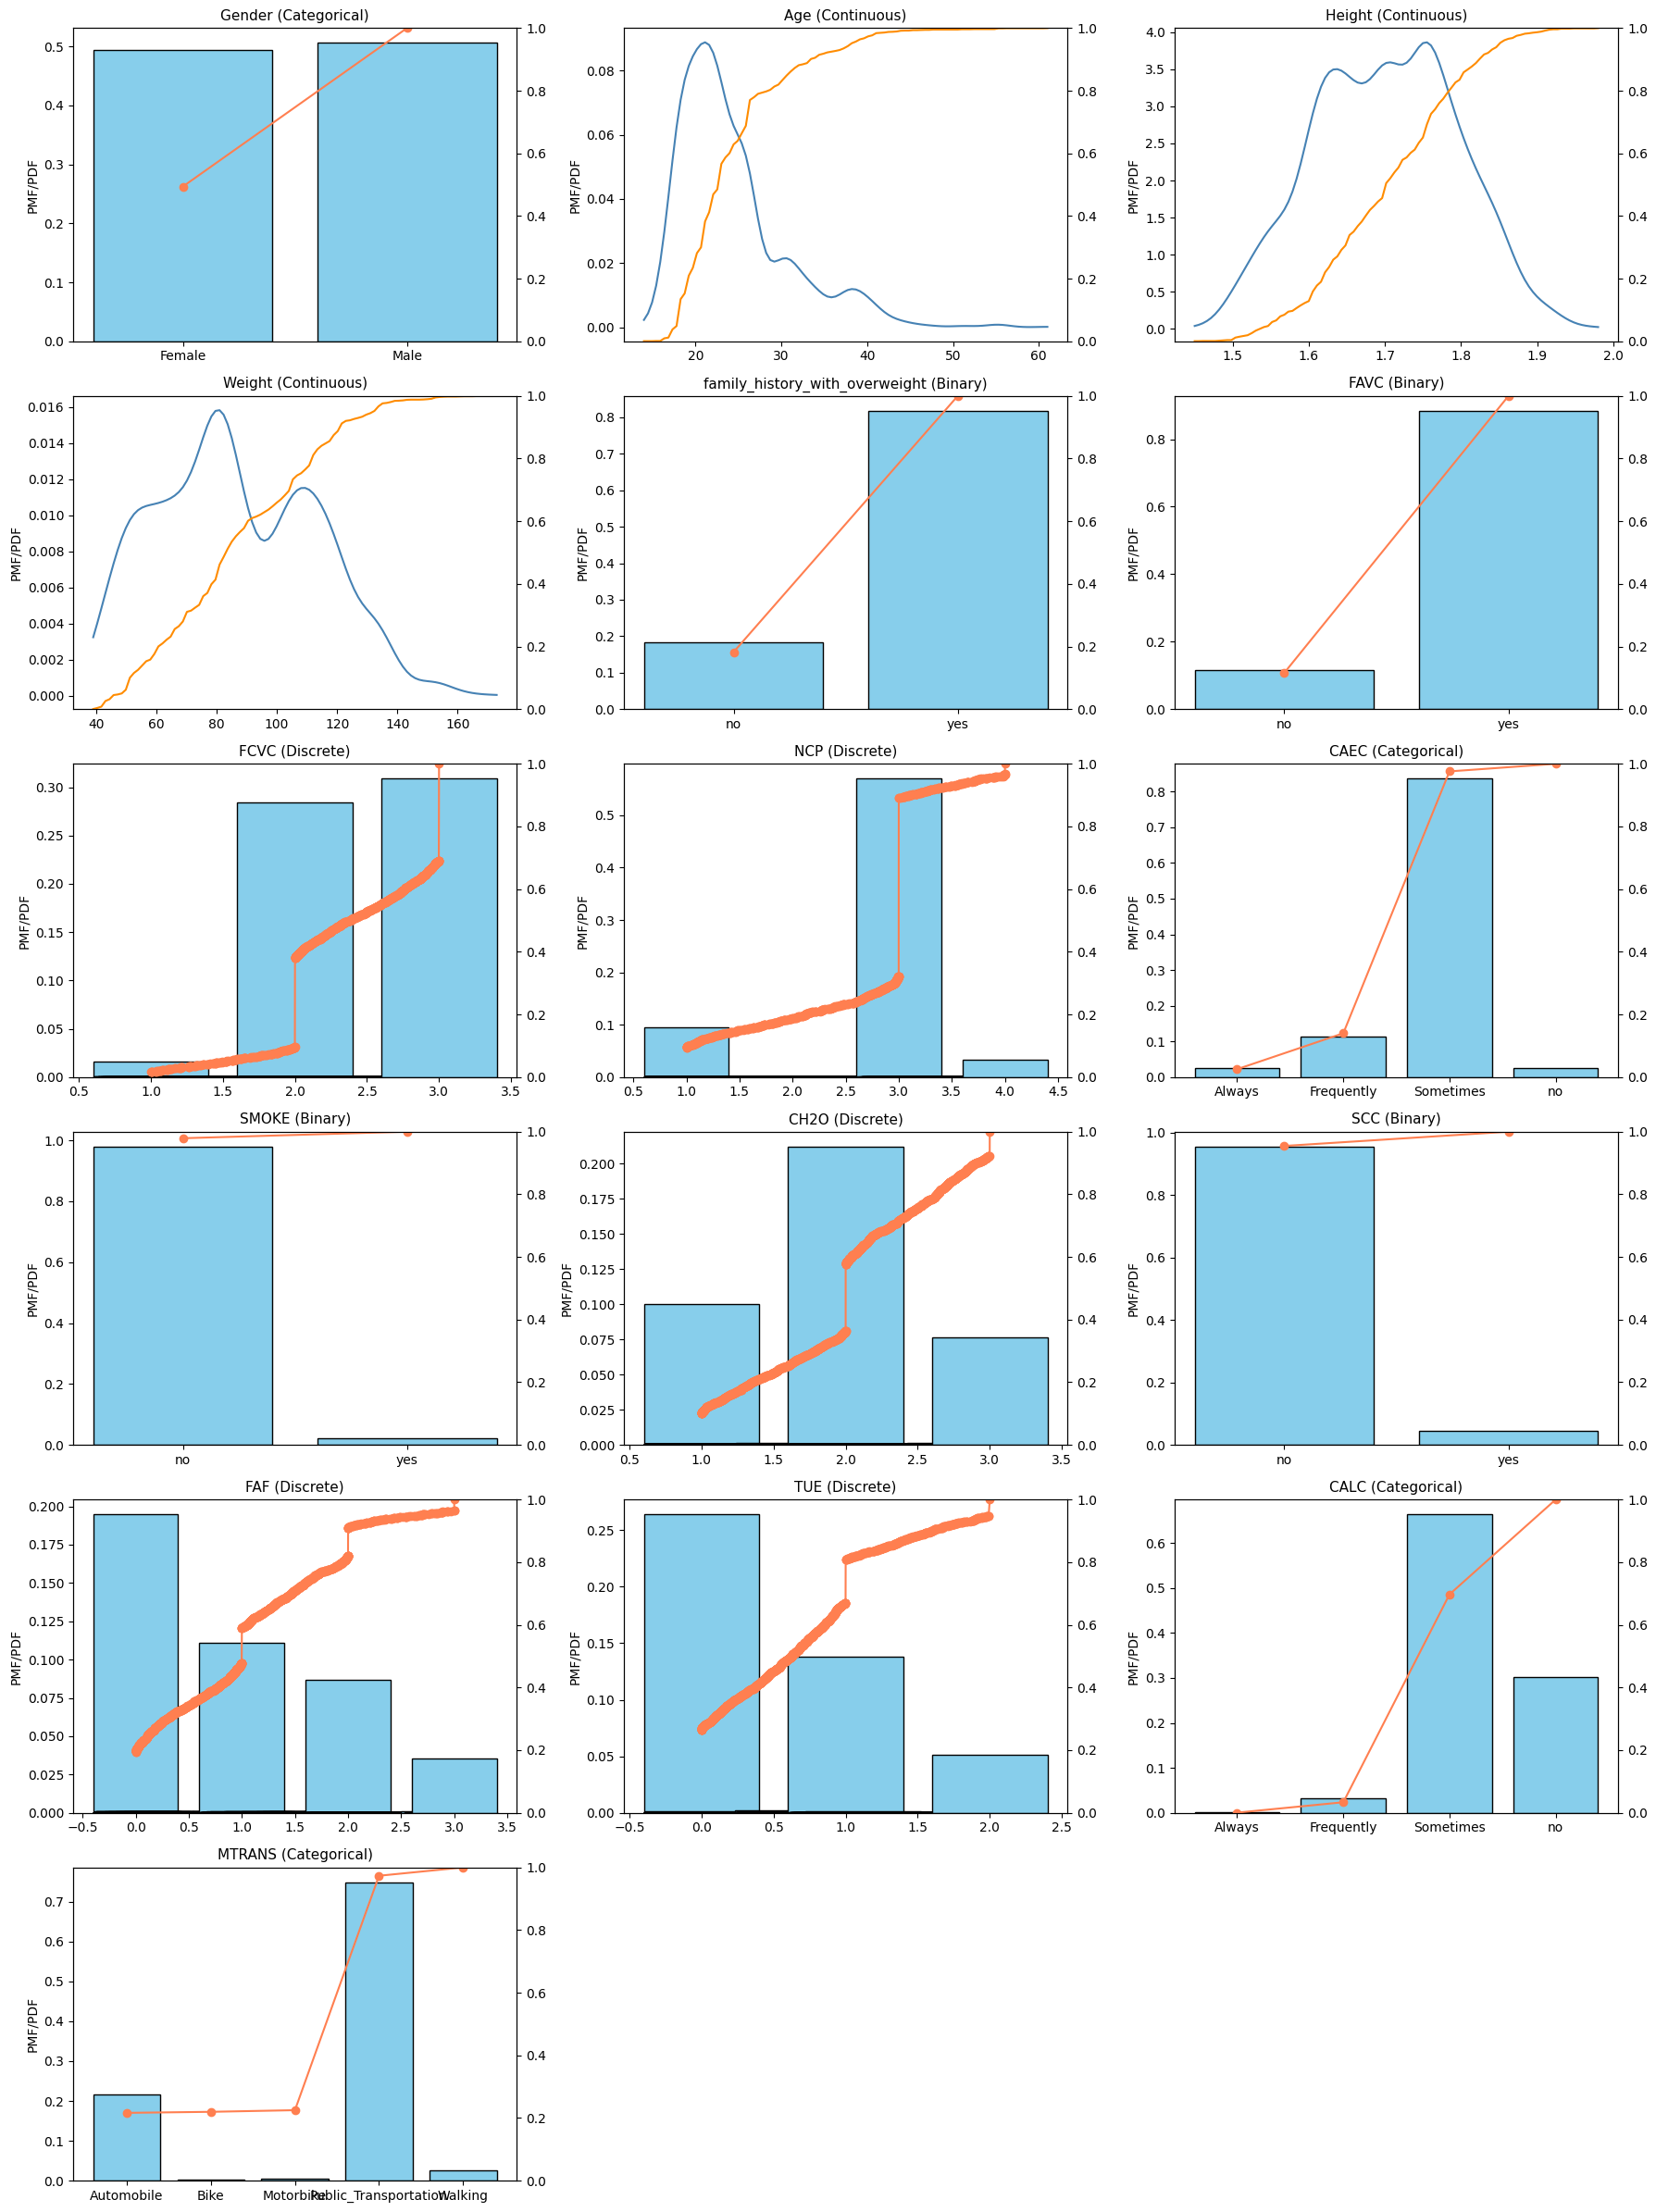

In [9]:
n = len(plots)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(18, nrows * 4))
axes = axes.flatten()

for i, (feature, ftype, x, y1, y2) in enumerate(plots):
  ax = axes[i]

  if ftype in ("Categorical", "Binary", "Discrete"):
    # PMF - barras
    ax.bar(x, y1, color="skyblue", edgecolor="k", label="PMF")
    # CDF - línea
    ax2 = ax.twinx()
    ax2.plot(x, y2, color="coral", label="CDF", marker="o")
    ax2.set_ylim(0, 1)
  else:
    # PDF - línea
    ax.plot(x, y1, color="steelblue", label="PDF (KDE)")
    # CDF - línea
    ax2 = ax.twinx()
    ax2.plot(x, y2, color="darkorange", label="ECDF")
    ax2.set_ylim(0, 1)

  ax.set_title(f"{feature} ({ftype})", fontsize=11)
  ax.set_xlabel("")
  ax.set_ylabel("PMF/PDF")

# Eliminar ejes vacíos
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Marginal Distributions.png", dpi=300, bbox_inches='tight')


# Analysis of Continuous Features

## a. Compute the conditional sample mean and sample variance, stratified by the four obesity levels.


In [10]:
# agrupar por nivel de obesidad y calculas promedio y varianza
cond_stats = data.groupby('NObeyesdad')[continuous_vars].agg(
    ['mean', 'var', 'min', 'max']).round(3)

# Modificar index para que se vea bonito
cond_stats.columns = ['_'.join(col).strip() for col in cond_stats.columns.values]

cond_stats.T

NObeyesdad,Insufficient Weight,Normal Weight,Obesity,Overweight
Age_mean,19.783,21.739,25.806,25.207
Age_var,7.126,25.977,35.034,54.369
Age_min,16.000,14.000,15.000,16.000
Age_max,39.000,61.000,52.000,56.000
Height_mean,1.691,1.677,1.716,1.696
Height_var,0.010,0.009,0.008,0.009
Height_min,1.520,1.500,1.500,1.450
Height_max,1.900,1.930,1.980,1.930
Weight_mean,49.906,62.155,109.082,78.176
Weight_var,36.129,86.416,301.213,86.772


## b.Test for an overall effect of obesity level on the feature using one-way ANOVA. Report the F-statistic and p-value.

In [11]:
anova_results = []

for var in continuous_vars:
  # Estraer grupos
  groups = [group[var].values for name, group in data.groupby('NObeyesdad')]

  # one-way ANOVA
  F_stat, p_val = f_oneway(*groups)
  anova_results.append([var, F_stat, p_val])

# crear DataFrame
anova_df = pd.DataFrame(anova_results, columns=['Feature', 'F-statistic', 'p-value'])
anova_df['Significant (p < 0.05)'] = anova_df['p-value'] < 0.05

In [12]:
anova_df.style.background_gradient(subset=['p-value'], cmap='Greens')

,Feature,F-statistic,p-value,Significant (p < 0.05)
0,Age,94.892632,0.000000,True
1,Height,16.364722,0.000000,True
2,Weight,1992.518260,0.000000,True


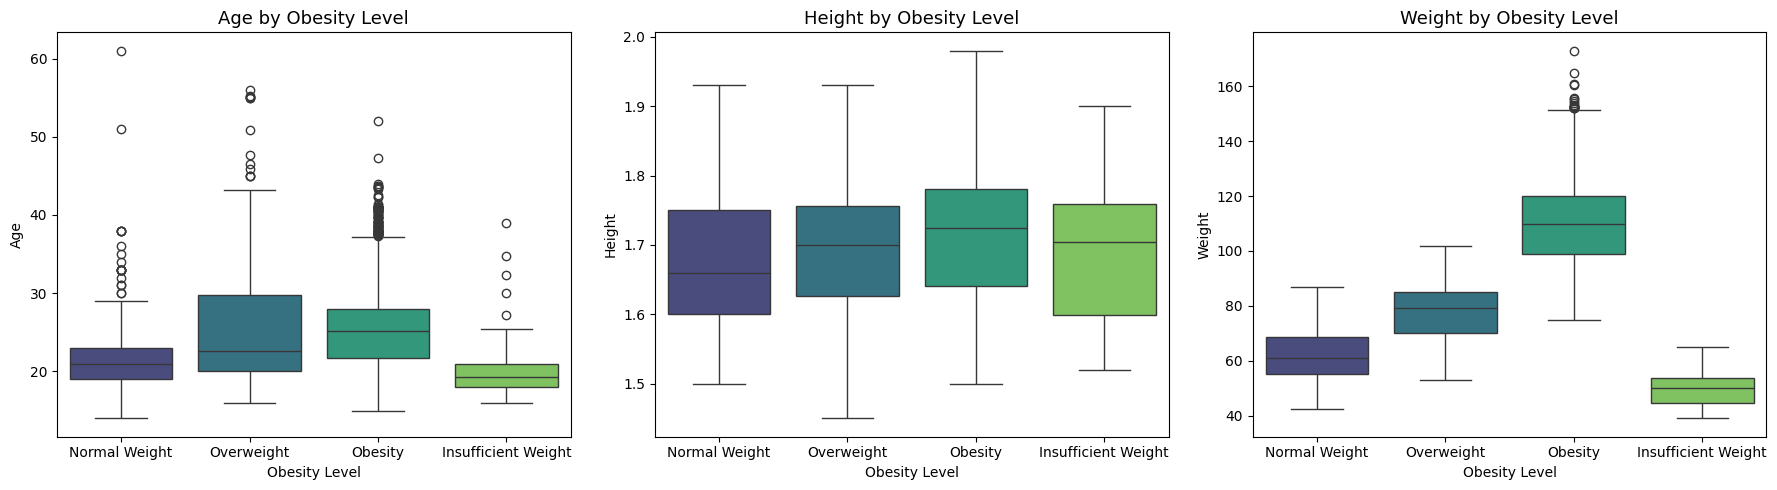

In [13]:
# plot resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, var in enumerate(continuous_vars):
  sns.boxplot(
    data=data,
    x='NObeyesdad',
    y=var,
    hue='NObeyesdad',
    palette='viridis',
    legend=False,
    ax=axes[i]
)
  axes[i].set_title(f'{var} by Obesity Level', fontsize=13)
  axes[i].set_xlabel('Obesity Level')
  axes[i].set_ylabel(var)
plt.tight_layout()
plt.savefig("ANOVA Results.png", dpi=300, bbox_inches='tight')


## ANOVA using lm() + aov()

In [41]:
anova_lm_results = {}

for feature in continuous_vars:
  model = smf.ols(f"{feature} ~ C(NObeyesdad)", data=data).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  anova_lm_results[feature] = anova_table
  print("ANOVA for:", feature)
  display(anova_table)
  print("\n")

ANOVA for: Age


,sum_sq,df,F,PR(>F)
C(NObeyesdad),10114.148060,3.0,94.892632,1.319997e-57
Residual,74858.323069,2107.0,NaN,NaN




ANOVA for: Height


,sum_sq,df,F,PR(>F)
C(NObeyesdad),0.418266,3.0,16.364722,1.632417e-10
Residual,17.950949,2107.0,NaN,NaN




ANOVA for: Weight


,sum_sq,df,F,PR(>F)
C(NObeyesdad),1.070187e+06,3.0,1992.51826,0.0
Residual,3.772252e+05,2107.0,NaN,NaN


## c. If the ANOVA is significant (p < 0.05), perform post-hoc pairwise comparisons of means (e.g., Tukey’s HSD) across the four levels. Apply false discovery rate (FDR) correction for multiple comparisons and report adjusted p-values.

In [14]:
# Creamos una lista para guardar resultados
tukey_results = []

# Iteramos cada variable continua significativa del ANOVA
for feature in continuous_vars:
  # Realizamos Tukey HSD
  tukey = pairwise_tukeyhsd(endog=data[feature],
                            groups=data['NObeyesdad'],
                            alpha=0.05)

  # Convertimos a DataFrame para manejar más fácil
  tukey_df = pd.DataFrame(data=tukey._results_table.data[1:],
                          columns=tukey._results_table.data[0])
  tukey_df.insert(0, 'Feature', feature)
  tukey_results.append(tukey_df)

# Unimos todas las tablas de Tukey
tukey_all = pd.concat(tukey_results, ignore_index=True)

# Aplicamos corrección FDR a todos los p-valores
reject, pvals_fdr, _, _ = multipletests(tukey_all['p-adj'], method='fdr_bh')
tukey_all['p-adj (FDR)'] = pvals_fdr
tukey_all['Significant (FDR < 0.05)'] = reject

# Mostramos la tabla final ordenada
tukey_all.sort_values(by=['Feature', 'group1', 'group2'], inplace=True)
tukey_all.reset_index(drop=True, inplace=True)

# Mostramos resumen
tukey_all.style.background_gradient(subset=['p-adj (FDR)'], cmap='RdYlGn_r').set_caption(
    "Post-hoc Tukey HSD with FDR Correction"
)


,Feature,group1,group2,meandiff,p-adj,lower,upper,reject,p-adj (FDR),Significant (FDR < 0.05)
0,Age,Insufficient Weight,Normal Weight,1.955400,0.000600,0.658600,3.252300,True,0.000831,True
1,Age,Insufficient Weight,Obesity,6.022900,0.000000,4.971700,7.074200,True,0.000000,True
2,Age,Insufficient Weight,Overweight,5.424100,0.000000,4.297900,6.550300,True,0.000000,True
3,Age,Normal Weight,Obesity,4.067500,0.000000,3.038000,5.097000,True,0.000000,True
4,Age,Normal Weight,Overweight,3.468700,0.000000,2.362600,4.574700,True,0.000000,True
5,Age,Obesity,Overweight,-0.598900,0.222000,-1.402900,0.205200,False,0.249750,False
6,Height,Insufficient Weight,Normal Weight,-0.014500,0.245600,-0.034600,0.005600,False,0.260047,False
7,Height,Insufficient Weight,Obesity,0.024400,0.000700,0.008200,0.040700,True,0.000900,True
8,Height,Insufficient Weight,Overweight,0.004700,0.901300,-0.012800,0.022100,False,0.901300,False
9,Height,Normal Weight,Obesity,0.039000,0.000000,0.023000,0.054900,True,0.000000,True


# 3. Analysis of Binary and Categorical Features


For each binary or categorical feature:


## a. Estimate the conditional prevalence (proportions) of each category, stratified by the four obesity levels.

In [15]:
# Seleccionamos las variables categóricas y binarias (excluyendo el target)
cat_bin_features = [
    'Gender',
    'family_history_with_overweight',
    'FAVC',
    'CAEC',
    'SMOKE',
    'SCC',
    'CALC',
    'MTRANS'
]


In [16]:
# Calculamos proporciones condicionales
prevalence_tables = {}

for feature in cat_bin_features:
  table = pd.crosstab(data['NObeyesdad'], data[feature], normalize='index') * 100
  prevalence_tables[feature] = table

# Resultados
for feature, table in prevalence_tables.items():
  display(pd.DataFrame(table.round(2)))
  print("\n" + "-"*70 + "\n")



Gender,Female,Male
NObeyesdad,,
Insufficient Weight,63.60,36.40
Normal Weight,49.13,50.87
Obesity,49.49,50.51
Overweight,42.76,57.24



----------------------------------------------------------------------



family_history_with_overweight,no,yes
NObeyesdad,,
Insufficient Weight,53.68,46.32
Normal Weight,45.99,54.01
Obesity,0.82,99.18
Overweight,17.07,82.93



----------------------------------------------------------------------



FAVC,no,yes
NObeyesdad,,
Insufficient Weight,18.75,81.25
Normal Weight,27.53,72.47
Obesity,1.95,98.05
Overweight,16.55,83.45



----------------------------------------------------------------------



CAEC,Always,Frequently,Sometimes,no
NObeyesdad,,,,
Insufficient Weight,0.74,44.49,53.68,1.10
Normal Weight,12.20,28.92,55.40,3.48
Obesity,0.82,0.82,98.15,0.21
Overweight,1.38,5.17,87.24,6.21



----------------------------------------------------------------------



SMOKE,no,yes
NObeyesdad,,
Insufficient Weight,99.63,0.37
Normal Weight,95.47,4.53
Obesity,97.74,2.26
Overweight,98.62,1.38



----------------------------------------------------------------------



SCC,no,yes
NObeyesdad,,
Insufficient Weight,91.91,8.09
Normal Weight,89.55,10.45
Obesity,99.69,0.31
Overweight,92.93,7.07



----------------------------------------------------------------------



CALC,Always,Frequently,Sometimes,no
NObeyesdad,,,,
Insufficient Weight,0.00,0.37,56.62,43.01
Normal Weight,0.35,6.27,56.10,37.28
Obesity,0.00,1.65,73.97,24.38
Overweight,0.00,6.03,63.28,30.69



----------------------------------------------------------------------



MTRANS,Automobile,Bike,Motorbike,Public_Transportation,Walking
NObeyesdad,,,,,
Insufficient Weight,16.91,0.00,0.00,80.88,2.21
Normal Weight,15.68,1.39,2.09,69.69,11.15
Obesity,21.19,0.10,0.31,78.09,0.31
Overweight,27.59,0.34,0.34,69.14,2.59



----------------------------------------------------------------------



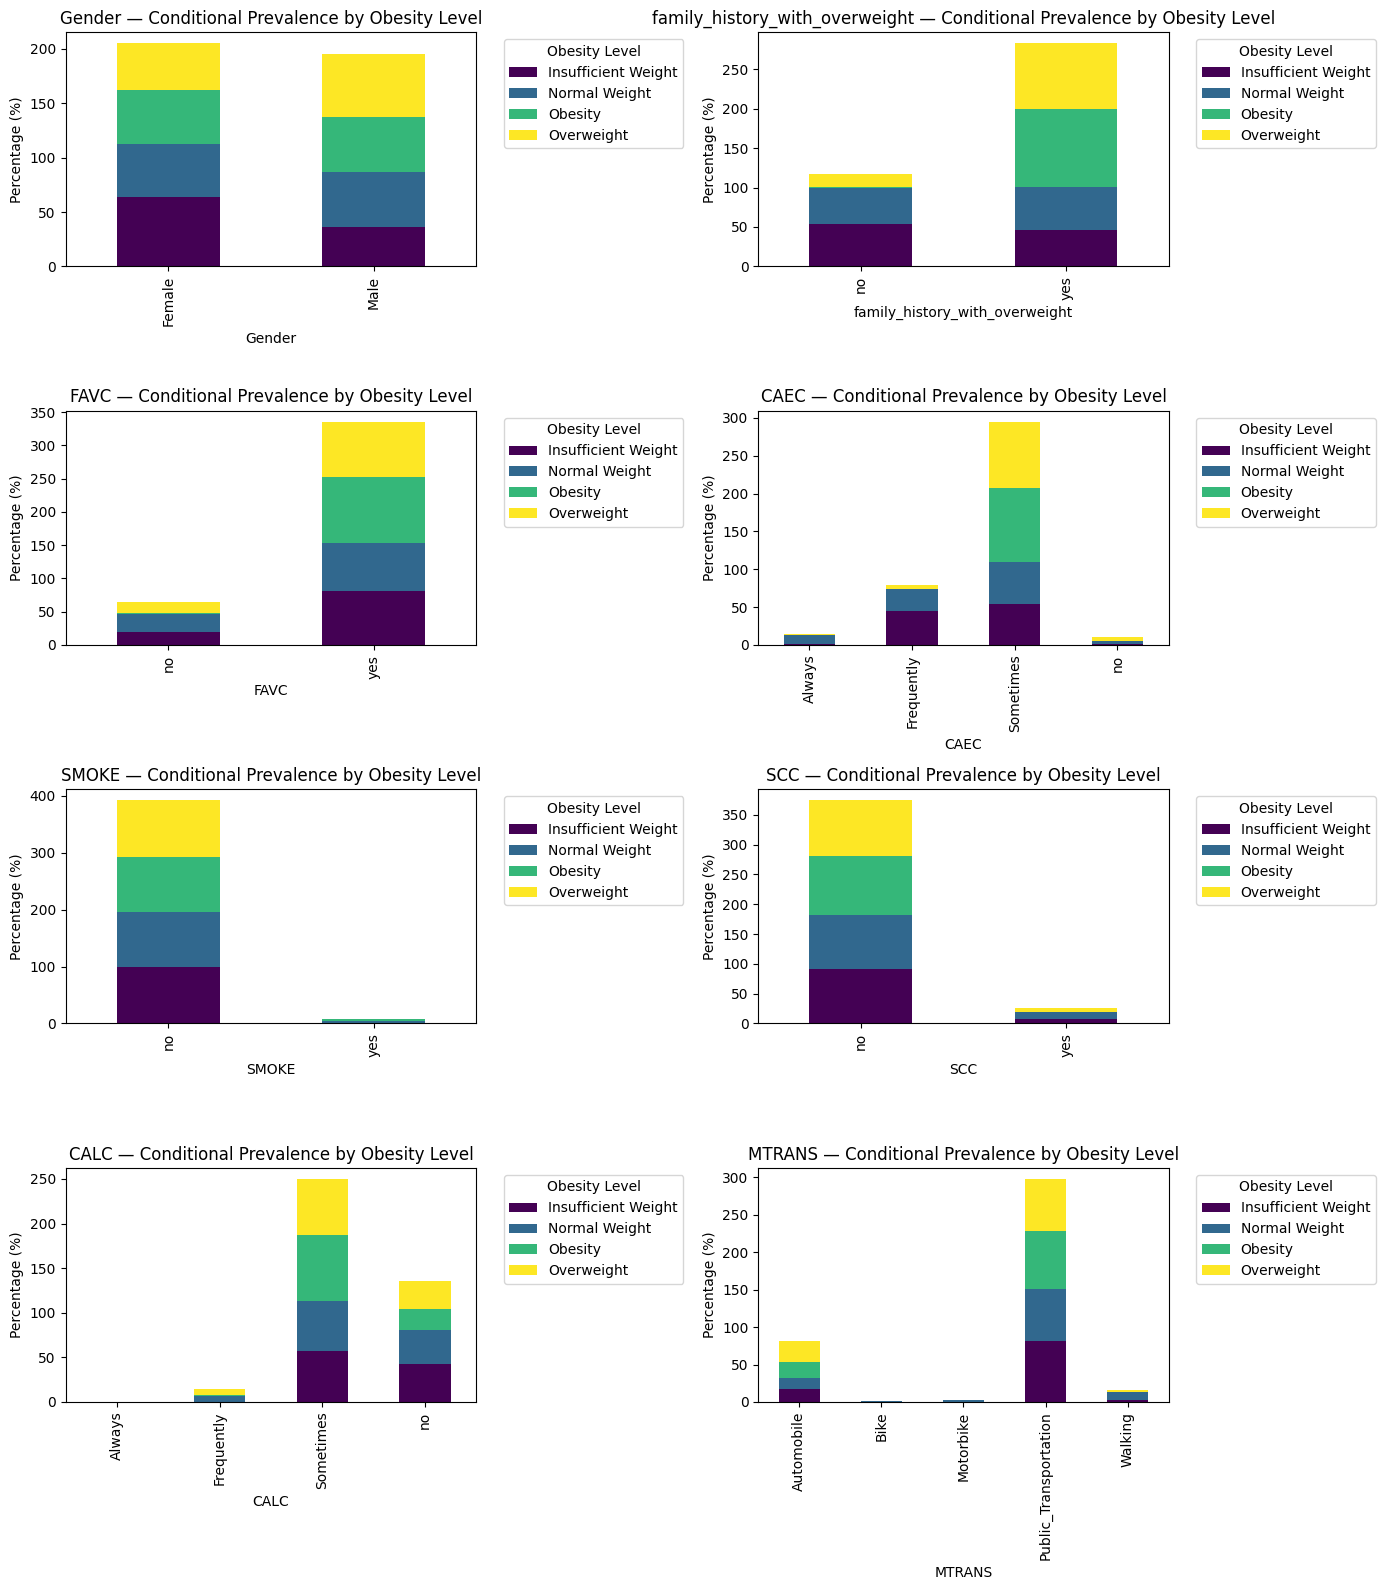

In [17]:
# Visualización: proporciones como gráficos de barras apiladas
fig, axes = plt.subplots(nrows=len(cat_bin_features)//2, ncols=2, figsize=(14, 16))
axes = axes.flatten()

for i, feature in enumerate(cat_bin_features):
  table = prevalence_tables[feature]
  table.T.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')
  axes[i].set_title(f'{feature} — Conditional Prevalence by Obesity Level')
  axes[i].set_ylabel('Percentage (%)')
  axes[i].legend(title='Obesity Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("Conditional Prevalence.png", dpi=300, bbox_inches='tight')


## b. Test for differences in prevalence across obesity levels using chi-squared tests (or Fisher’s exact test for binary features with low counts). Apply FDR correction for multiple comparisons and report adjusted p-values.

In [37]:
results = []

for var in categorical_vars:
  contingency = pd.crosstab(data[var], data['NObeyesdad'])

  # Determinar si aplicar Fisher o Chi2
  if contingency.shape == (2, 2) and (contingency.values < 5).any():
    test_name = "Fisher's Exact"
    stat, p = fisher_exact(contingency)
    df = "n/a"
  else:
    test_name = "Chi-squared"
    stat, p, dof, expected = chi2_contingency(contingency)
    df = dof

  results.append({
    'Feature': var,
    'Test': test_name,
    'Statistic': stat,
    'df': df,
    'p-value': p
  })

# Convertir a DataFrame
chi_results = pd.DataFrame(results)

# Aplicar corrección FDR
chi_results['p-adjusted (FDR)'] = multipletests(chi_results['p-value'], method='fdr_bh')[1]
chi_results['Significant (FDR<0.05)'] = chi_results['p-adjusted (FDR)'] < 0.05

chi_results = chi_results.sort_values('p-adjusted (FDR)')

chi_results

,Feature,Test,Statistic,df,p-value,p-adjusted (FDR),Significant (FDR<0.05)
3,CAEC,Chi-squared,715.051862,9,4.014705e-148,3.211764e-147,True
1,family_history_with_overweight,Chi-squared,575.571169,3,1.990907e-124,7.963626e-124,True
2,FAVC,Chi-squared,186.518899,3,3.447840e-40,9.194239e-40,True
7,MTRANS,Chi-squared,150.150517,12,5.284884e-26,1.056977e-25,True
5,SCC,Chi-squared,79.642730,3,3.661575e-17,5.858521e-17,True
6,CALC,Chi-squared,90.328875,9,1.398545e-15,1.864726e-15,True
0,Gender,Chi-squared,32.196306,3,4.757888e-07,5.437587e-07,True
4,SMOKE,Chi-squared,13.901526,3,3.042303e-03,3.042303e-03,True


# 4. Conditional Distributions

## For each feature, compute the conditional PMF/PDF and CDF, stratified by the four obesity levels. (For continuous features, use kernel density estimation for PDFs if needed; for discrete, use empirical frequencies.)

In [19]:
obesity_levels = data['NObeyesdad'].unique()

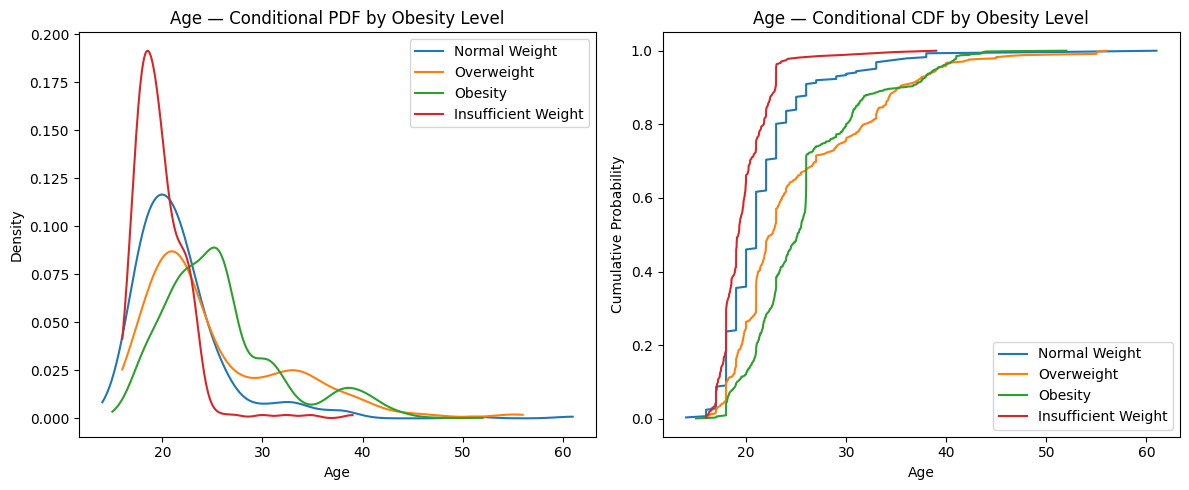

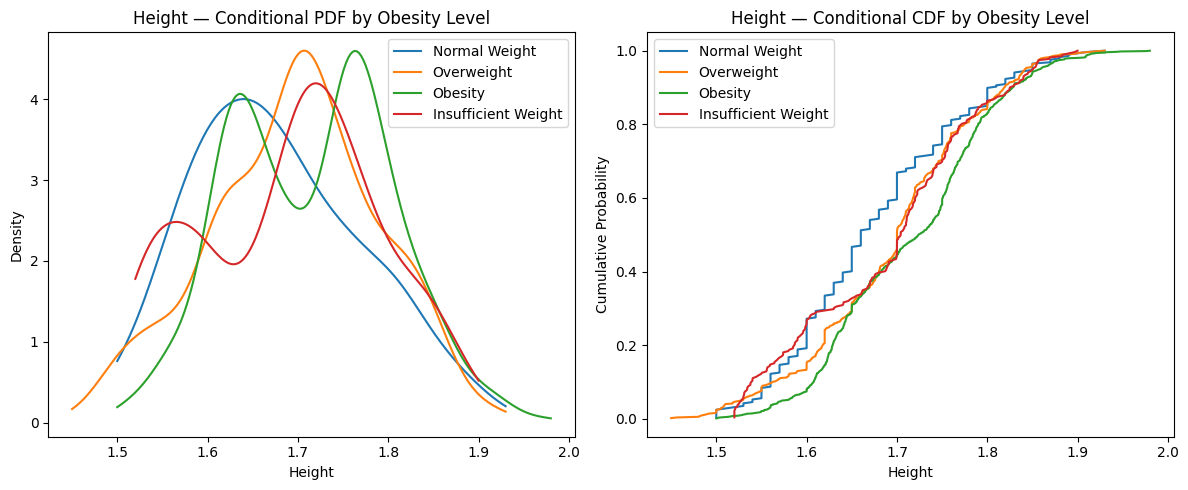

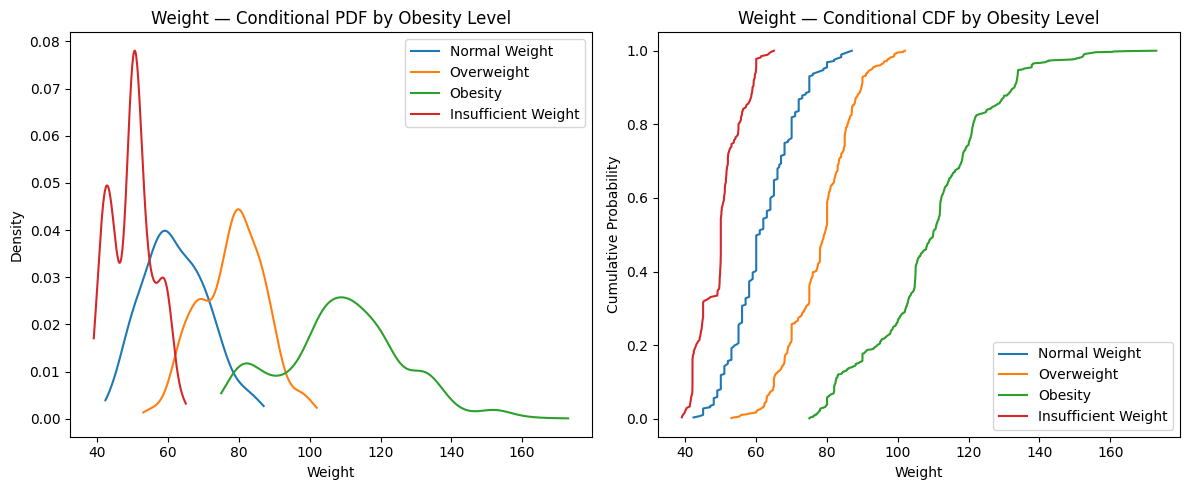

In [20]:
# Continuous Features — Conditional PDF and CDF

for feature in continuous_vars:
  plt.figure(figsize=(12,5))

  # PDF using KDE
  plt.subplot(1, 2, 1)
  for level in obesity_levels:
    subset = data[data['NObeyesdad'] == level][feature].dropna()
    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 200)
    plt.plot(x_vals, kde(x_vals), label=level)
  plt.title(f'{feature} — Conditional PDF by Obesity Level')
  plt.xlabel(feature)
  plt.ylabel('Density')
  plt.legend()

  # CDF using ECDF
  plt.subplot(1, 2, 2)
  for level in obesity_levels:
    subset = data[data['NObeyesdad'] == level][feature].dropna()
    ecdf = ECDF(subset)
    plt.plot(ecdf.x, ecdf.y, label=level)
  plt.title(f'{feature} — Conditional CDF by Obesity Level')
  plt.xlabel(feature)
  plt.ylabel('Cumulative Probability')
  plt.legend()

  plt.tight_layout()
  plt.savefig(f"Continuous Features: PDF and CDF.png", dpi=300, bbox_inches='tight')


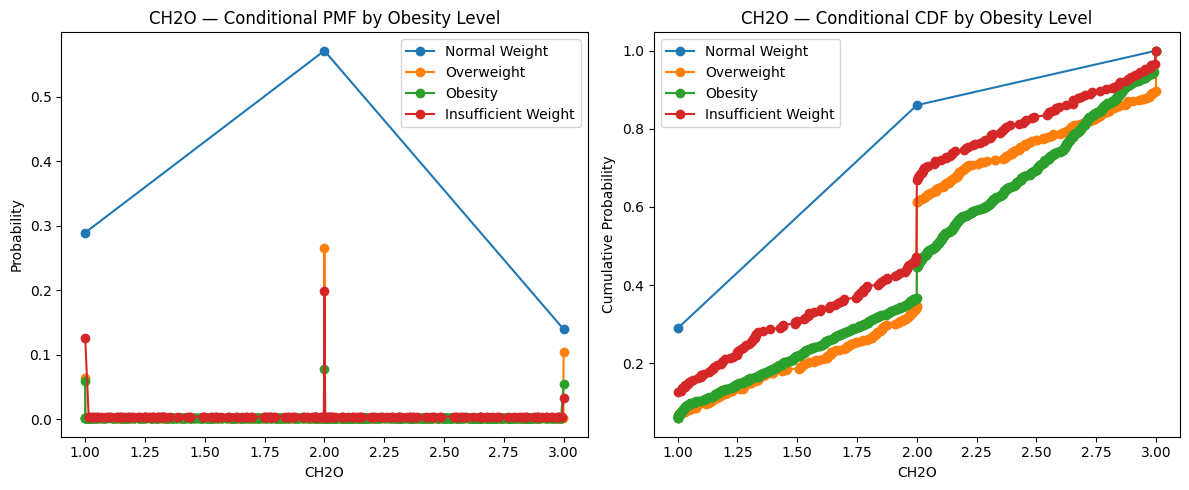

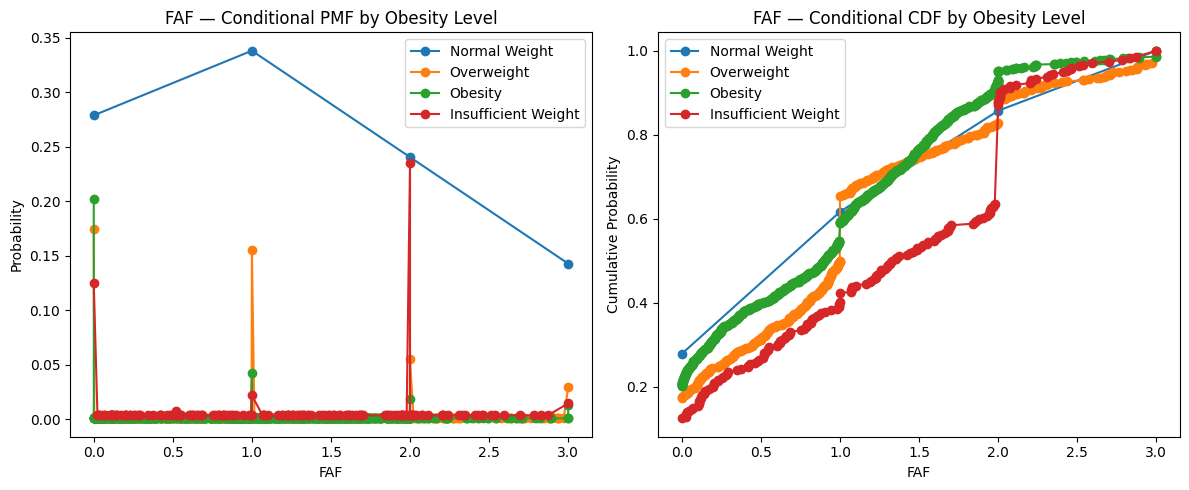

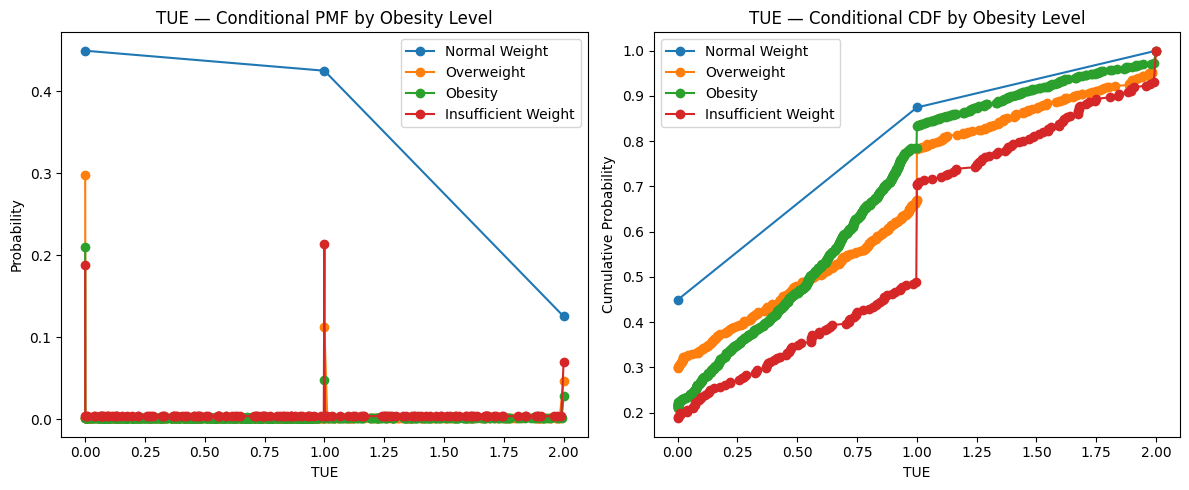

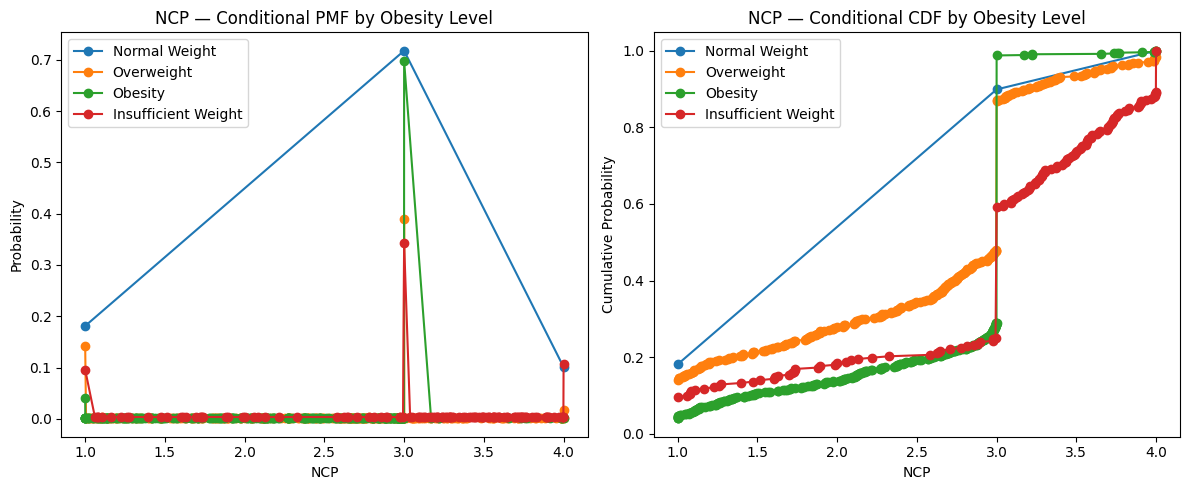

In [21]:
# Discrete Features — Conditional PMF and CDF
for feature in discrete_vars:
  plt.figure(figsize=(12,5))

  # PMF (probability mass function)
  plt.subplot(1, 2, 1)
  for level in obesity_levels:
    subset = data[data['NObeyesdad'] == level][feature].dropna()
    values, counts = np.unique(subset, return_counts=True)
    pmf = counts / counts.sum()
    plt.plot(values, pmf, marker='o', label=level)
  plt.title(f'{feature} — Conditional PMF by Obesity Level')
  plt.xlabel(feature)
  plt.ylabel('Probability')
  plt.legend()

  # CDF (empirical)
  plt.subplot(1, 2, 2)
  for level in obesity_levels:
    subset = data[data['NObeyesdad'] == level][feature].dropna()
    values, counts = np.unique(subset, return_counts=True)
    cdf = np.cumsum(counts) / counts.sum()
    plt.plot(values, cdf, marker='o', label=level)
  plt.title(f'{feature} — Conditional CDF by Obesity Level')
  plt.xlabel(feature)
  plt.ylabel('Cumulative Probability')
  plt.legend()

  plt.tight_layout()
  plt.savefig(f"Discrete Features: PMF and CDF.png", dpi=300, bbox_inches='tight')

<Figure size 800x500 with 0 Axes>

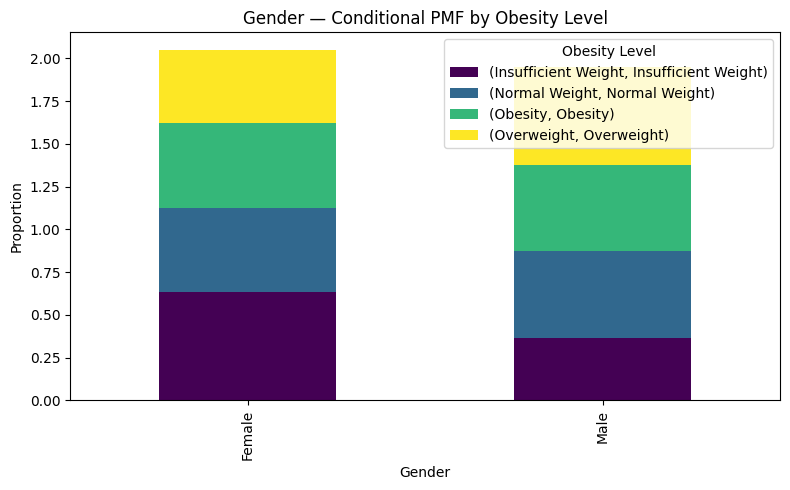

<Figure size 800x500 with 0 Axes>

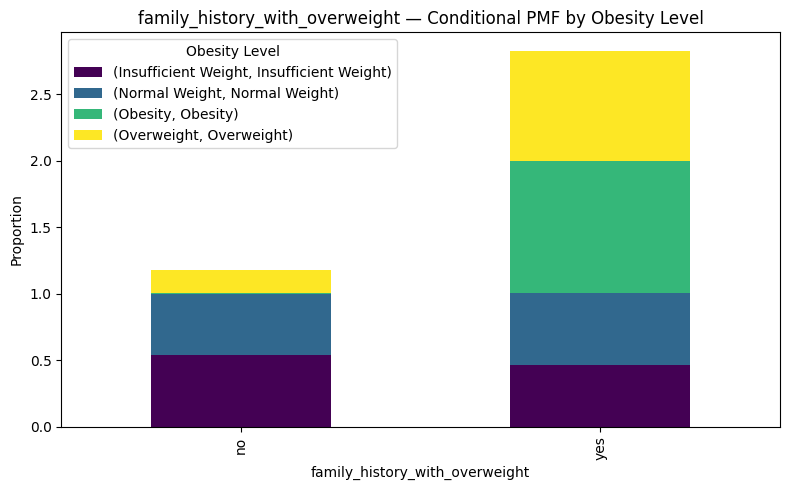

<Figure size 800x500 with 0 Axes>

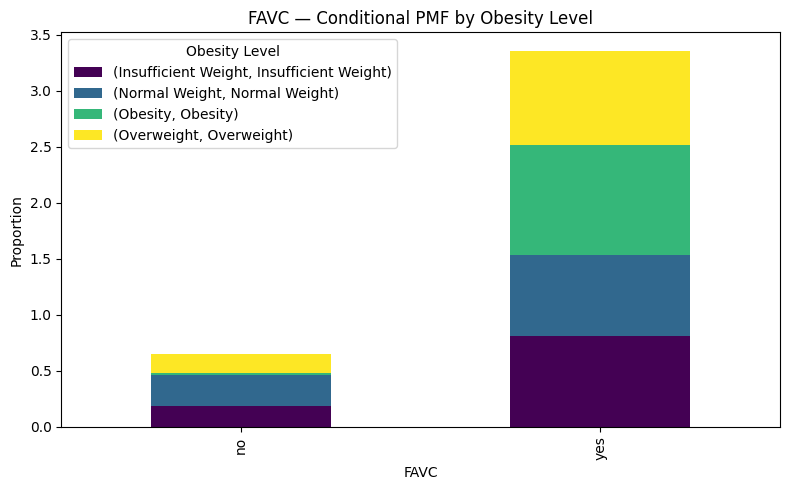

<Figure size 800x500 with 0 Axes>

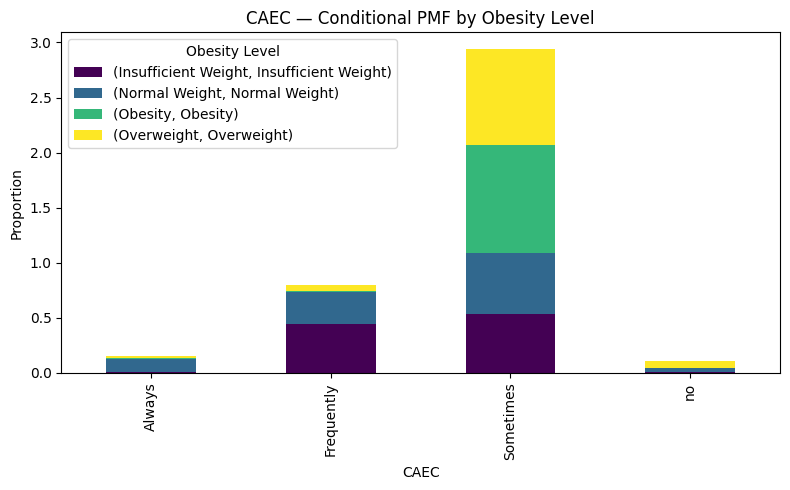

<Figure size 800x500 with 0 Axes>

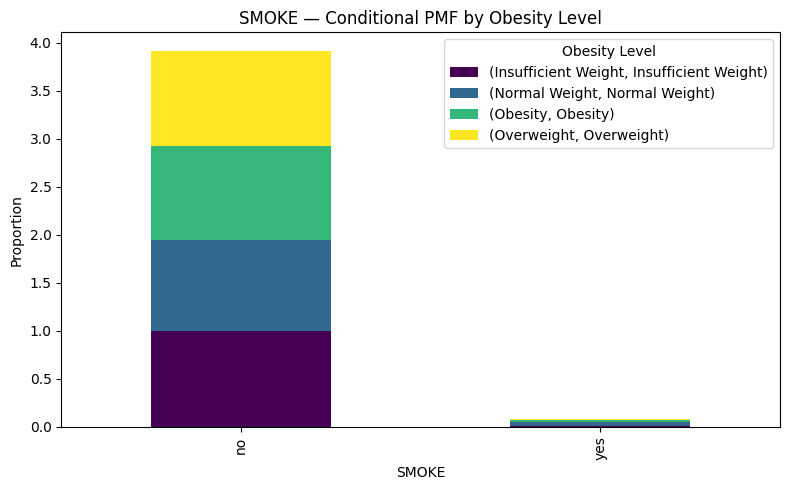

<Figure size 800x500 with 0 Axes>

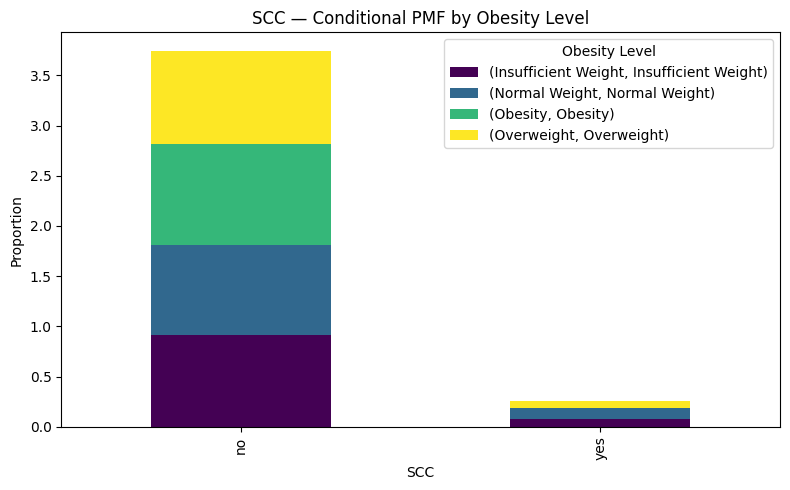

<Figure size 800x500 with 0 Axes>

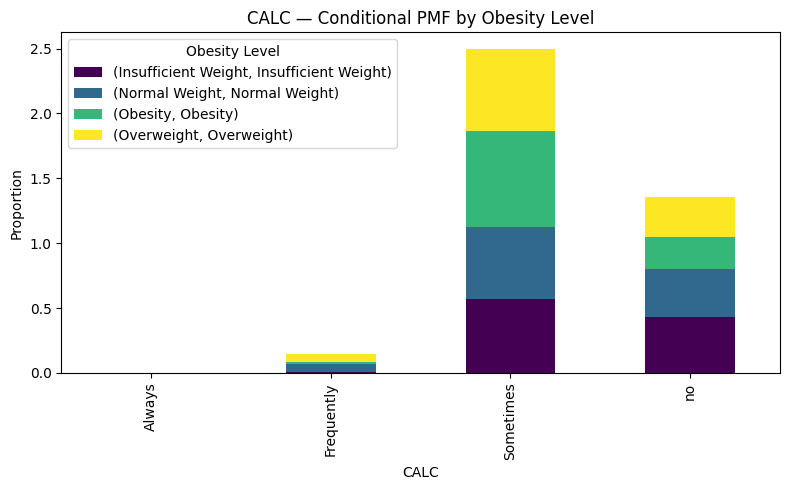

<Figure size 800x500 with 0 Axes>

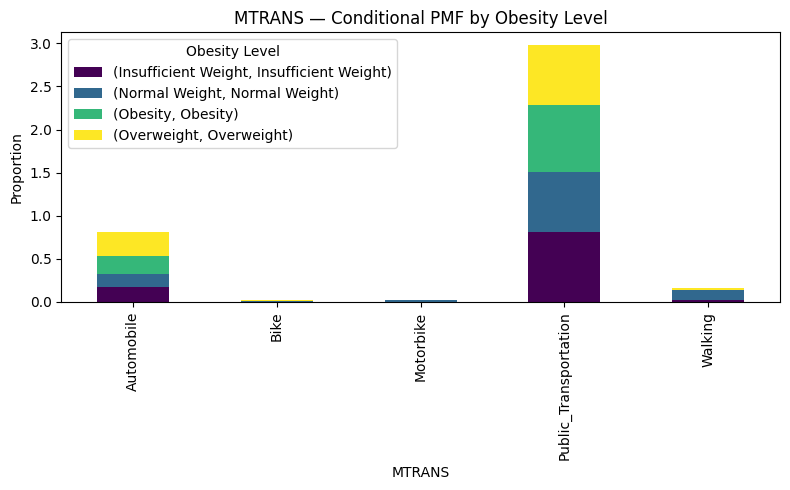

In [22]:
# Categorical Features — Conditional PMF
for feature in categorical_vars:
  plt.figure(figsize=(8,5))

  proportions = (
    data.groupby(['NObeyesdad', feature]).size()
    .groupby(level=0).apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
  )
  proportions.T.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')
  plt.title(f'{feature} — Conditional PMF by Obesity Level')
  plt.ylabel('Proportion')
  plt.xlabel(feature)
  plt.legend(title='Obesity Level')
  plt.tight_layout()
  plt.savefig(f"Categorical Features: PMF.png", dpi=300, bbox_inches='tight')

# 5. Model-Based Expectations for Continuous Features


For each continuous feature and each of the four obesity levels, use the estimated conditional PDF/CDF to:


## a. Compute the expected (model-based) conditional mean and variance.


In [23]:
mode_base_results = []

# Número de puntos donde evaluamos la KDE
grid_size = 200

for feature in continuous_vars:
  for level in obesity_levels:
    values = data.loc[data["NObeyesdad"] == level, feature].dropna().values

    kde = gaussian_kde(values)

    x_grid = np.linspace(values.min(), values.max(), grid_size)
    pdf_vals = kde(x_grid)

    # Normalizar correctamente usando integral
    pdf_vals = pdf_vals / np.trapezoid(pdf_vals, x_grid)

    # dx
    dx = x_grid[1] - x_grid[0]

    # Modelo
    mean_kde = np.trapezoid(x_grid * pdf_vals, x_grid)
    var_kde = np.trapezoid((x_grid - mean_kde)**2 * pdf_vals, x_grid)

    mode_base_results.append({
        "Feature": feature,
        "Obesity Level": level,
        "Model-based Mean": mean_kde,
        "Model-based Variance": var_kde
    })


In [24]:
# Convertimos a tabla
df_model_expectations = pd.DataFrame(mode_base_results)
df_model_expectations

,Feature,Obesity Level,Model-based Mean,Model-based Variance
0,Age,Normal Weight,21.732294,25.397568
1,Age,Overweight,25.463169,52.870510
2,Age,Obesity,25.822881,36.608148
3,Age,Insufficient Weight,19.851800,6.855189
4,Height,Normal Weight,1.679362,0.008918
5,Height,Overweight,1.695890,0.008988
6,Height,Obesity,1.716036,0.008182
7,Height,Insufficient Weight,1.698969,0.008842
8,Weight,Normal Weight,62.159021,87.971705
9,Weight,Overweight,78.136498,88.899229


i. ¿La media basada en la KDE es equivalente a la media muestral?

Respuesta corta:
✔ Sí, deberían ser prácticamente equivalentes — siempre y cuando la KDE esté correctamente normalizada y uses un número razonable de puntos (como los 200 que usamos).

Por qué:
La esperanza matemática estimada con KDE:

𝜇
^
𝐾
𝐷
𝐸
= ∫
𝑥
𝑓
𝐾
𝐷
𝐸
(
𝑥
)

𝑑
𝑥

es un suavizado de la distribución empírica.

Si tienes bastantes datos (como en este dataset), la KDE debe aproximar la misma media muestral:

𝜇
^
𝑠
𝑎
𝑚
𝑝
𝑙
𝑒
=1 /𝑛
∑
𝑥
𝑖


## Comparison between sample mean/variance and KDE-based

In [25]:
tolerance = 1e-3

continuous_features = ["Age", "Height", "Weight"]
obesity_levels = cond_stats.index.tolist()

results = []

for feat in continuous_features:
  for level in obesity_levels:
    # Sample stats
    sample_mean = cond_stats.loc[level, f"{feat}_mean"]
    sample_var  = cond_stats.loc[level, f"{feat}_var"]

    # Model stats (from KDE)
    row = df_model_expectations[
      (df_model_expectations["Feature"] == feat) &
      (df_model_expectations["Obesity Level"] == level)
    ]
    model_mean = row["Model-based Mean"].values[0]
    model_var  = row["Model-based Variance"].values[0]

    results.append([
      feat,
      level,
      sample_mean,
      model_mean,
      abs(sample_mean - model_mean) < tolerance,
      sample_var,
      model_var,
      abs(sample_var - model_var) < tolerance
    ])

comparison_df = pd.DataFrame(results, columns=[
  "Feature", "Obesity Level",
  "Sample Mean", "Model-based Mean", "Mean Equivalent?",
  "Sample Var",  "Model-based Var",  "Var Equivalent?"
])

comparison_df


,Feature,Obesity Level,Sample Mean,Model-based Mean,Mean Equivalent?,Sample Var,Model-based Var,Var Equivalent?
0,Age,Insufficient Weight,19.783,19.851800,False,7.126,6.855189,False
1,Age,Normal Weight,21.739,21.732294,False,25.977,25.397568,False
2,Age,Obesity,25.806,25.822881,False,35.034,36.608148,False
3,Age,Overweight,25.207,25.463169,False,54.369,52.870510,False
4,Height,Insufficient Weight,1.691,1.698969,False,0.010,0.008842,False
5,Height,Normal Weight,1.677,1.679362,False,0.009,0.008918,True
6,Height,Obesity,1.716,1.716036,True,0.008,0.008182,True
7,Height,Overweight,1.696,1.695890,True,0.009,0.008988,True
8,Weight,Insufficient Weight,49.906,50.097407,False,36.129,36.158883,False
9,Weight,Normal Weight,62.155,62.159021,False,86.416,87.971705,False


## Compute 95% bounded support intervals

In [43]:
bounded_support = []

for feature in continuous_vars:
  for level in obesity_levels:
    vals = data.loc[data["NObeyesdad"] == level, feature].dropna().values

    # KDE
    kde = gaussian_kde(vals)
    x_grid = np.linspace(vals.min(), vals.max(), 500)
    pdf_vals = kde(x_grid)
    pdf_vals /= pdf_vals.sum()  # normalize

    # Compute empirical 2.5% and 97.5% quantiles using KDE-CDF
    cdf_vals = np.cumsum(pdf_vals)
    cdf_vals /= cdf_vals.max()

    low = x_grid[np.searchsorted(cdf_vals, 0.025)]
    high = x_grid[np.searchsorted(cdf_vals, 0.975)]

    bounded_support.append({
        "Feature": feature,
        "Level": level,
        "2.5%": round(low, 3),
        "97.5%": round(high, 3)
    })

bounded_support_df = pd.DataFrame(bounded_support)
bounded_support_df

,Feature,Level,2.5%,97.5%
0,Age,Insufficient Weight,16.415,24.665
1,Age,Normal Weight,15.413,35.287
2,Age,Obesity,17.150,41.026
3,Age,Overweight,16.721,42.613
4,Height,Insufficient Weight,1.531,1.871
5,Height,Normal Weight,1.523,1.876
6,Height,Obesity,1.552,1.890
7,Height,Overweight,1.502,1.869
8,Weight,Insufficient Weight,40.042,61.822
9,Weight,Normal Weight,45.704,81.804


# 6. Discriminative Intervals and Bootstrap Evaluation

For each continuous feature:

## a. Identify discriminative intervals (a,b] where the conditional PDF for one obesity level significantly differs from the PDFs of the other levels (e.g., via Kolmogorov-Smirnov tests or visual inspection of overlaid densities).

In [26]:
grid_size = 300

discriminative_intervals = []

for feature in continuous_vars:
  kdes = {}
  x_grids = {}

  # KDE por nivel
  for level in obesity_levels:
    vals = data.loc[data["NObeyesdad"] == level, feature].dropna().values
    kde = gaussian_kde(vals)
    x_grid = np.linspace(vals.min(), vals.max(), grid_size)

    kdes[level] = kde(x_grid)
    x_grids[level] = x_grid

  ref_grid = list(x_grids.values())[0]

  # Determinar intervalos donde una clase domina
  for target in obesity_levels:
    target_pdf = kdes[target]
    others = [lvl for lvl in obesity_levels if lvl != target]

    dominance_mask = np.ones(grid_size, dtype=bool)

    for other in others:
      other_pdf = kdes[other]
      dominance_mask &= (target_pdf > other_pdf)

    # Convertimos la máscara en intervalos
    intervals = []
    start = None

    for i in range(grid_size):
      if dominance_mask[i] and start is None:
        start = i
      elif not dominance_mask[i] and start is not None:
        intervals.append((ref_grid[start], ref_grid[i]))
        start = None

    if start is not None:  # si termina al final
      intervals.append((ref_grid[start], ref_grid[-1]))

    discriminative_intervals.append({
      "Feature": feature,
      "Target Level": target,
      "Intervals (a,b]": intervals
    })

disc_df = pd.DataFrame(discriminative_intervals)
disc_df

,Feature,Target Level,"Intervals (a,b]"
0,Age,Insufficient Weight,"[(16.0, 22.153846153846153), (34.6923076923076..."
1,Age,Normal Weight,[]
2,Age,Obesity,"[(22.153846153846153, 26.46153846153846), (29...."
3,Age,Overweight,"[(26.46153846153846, 29.46153846153846), (36.0..."
4,Height,Insufficient Weight,"[(1.52, 1.5721070234113712), (1.68775919732441..."
5,Height,Normal Weight,"[(1.5721070234113712, 1.6165886287625417), (1...."
6,Height,Obesity,"[(1.6165886287625417, 1.6356521739130434), (1...."
7,Height,Overweight,"[(1.7017391304347826, 1.7271571906354515), (1...."
8,Weight,Insufficient Weight,"[(39.0, 46.130434782608695), (47.3478260869565..."
9,Weight,Normal Weight,"[(46.130434782608695, 47.34782608695652)]"


## b. Use bootstrap resampling (n = 1,000 iterations) to evaluate the feature as a binary classifier for detecting each obesity level (one-vs-rest):
- Compute the receiver operating characteristic (ROC) curve and area under the curve (AUC) with 95% confidence intervals (CIs).
- For a fixed threshold (e.g., maximizing Youden’s J statistic), compute the confusion matrix.

In [27]:
target = target_col
levels = data[target].unique()

results_auc = []
results_cm = []

n_boot = 1000  # bootstrap iterations

for feat in continuous_features:
  X = data[feat].values

  for lvl in levels:
    # One-vs-rest labels
    y = (data[target] == lvl).astype(int).values

    # Guarda AUCs bootstrap
    auc_scores = []

    #  Bootstrap AUC
    for _ in range(n_boot):
      Xb, yb = resample(X, y, replace=True)

      # Evitar errores si una muestra bootstrap solo tiene una clase
      if len(np.unique(yb)) < 2:
          continue

      auc = roc_auc_score(yb, Xb)
      auc_scores.append(auc)

    # Intervalo de confianza
    if len(auc_scores) == 0:
      ci_low, ci_high = np.nan, np.nan
      auc_mean = np.nan
    else:
      auc_mean = np.mean(auc_scores)
      ci_low  = np.percentile(auc_scores, 2.5)
      ci_high = np.percentile(auc_scores, 97.5)

    results_auc.append({
      "Feature": feat,
      "Target Level": lvl,
      "AUC Mean": auc_mean,
      "95% CI Low": ci_low,
      "95% CI High": ci_high,
    })

    # Threshold óptimo (Youden J)
    fpr, tpr, thresholds = roc_curve(y, X)

    J = tpr - fpr
    best_idx = np.argmax(J)
    best_thr = thresholds[best_idx]

    # Matriz de confusión
    y_pred = (X >= best_thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    results_cm.append({
      "Feature": feat,
      "Target Level": lvl,
      "Threshold": best_thr,
      "TN": tn, "FP": fp, "FN": fn, "TP": tp
    })

df_auc = pd.DataFrame(results_auc)
df_cm  = pd.DataFrame(results_cm)

df_auc

,Feature,Target Level,AUC Mean,95% CI Low,95% CI High
0,Age,Normal Weight,0.340165,0.308814,0.371806
1,Age,Overweight,0.528074,0.499454,0.556230
2,Age,Obesity,0.687193,0.664209,0.709570
3,Age,Insufficient Weight,0.203067,0.181110,0.227652
4,Height,Normal Weight,0.404462,0.367773,0.439541
5,Height,Overweight,0.480551,0.452099,0.508225
6,Height,Obesity,0.574297,0.548463,0.599249
7,Height,Insufficient Weight,0.468698,0.432562,0.507484
8,Weight,Normal Weight,0.169030,0.150992,0.186558
9,Weight,Overweight,0.382207,0.359105,0.405249


In [28]:
df_cm

,Feature,Target Level,Threshold,TN,FP,FN,TP
0,Age,Normal Weight,61.000000,1824,0,286,1
1,Age,Overweight,26.047077,1225,306,393,187
2,Age,Obesity,22.200779,720,419,280,692
3,Age,Insufficient Weight,16.000000,2,1837,0,272
4,Height,Normal Weight,1.870000,1772,52,277,10
5,Height,Overweight,1.672101,622,909,210,370
6,Height,Obesity,1.732383,762,377,498,474
7,Height,Insufficient Weight,1.686936,809,1030,108,164
8,Weight,Normal Weight,45.000000,74,1750,2,285
9,Weight,Overweight,60.117993,409,1122,11,569


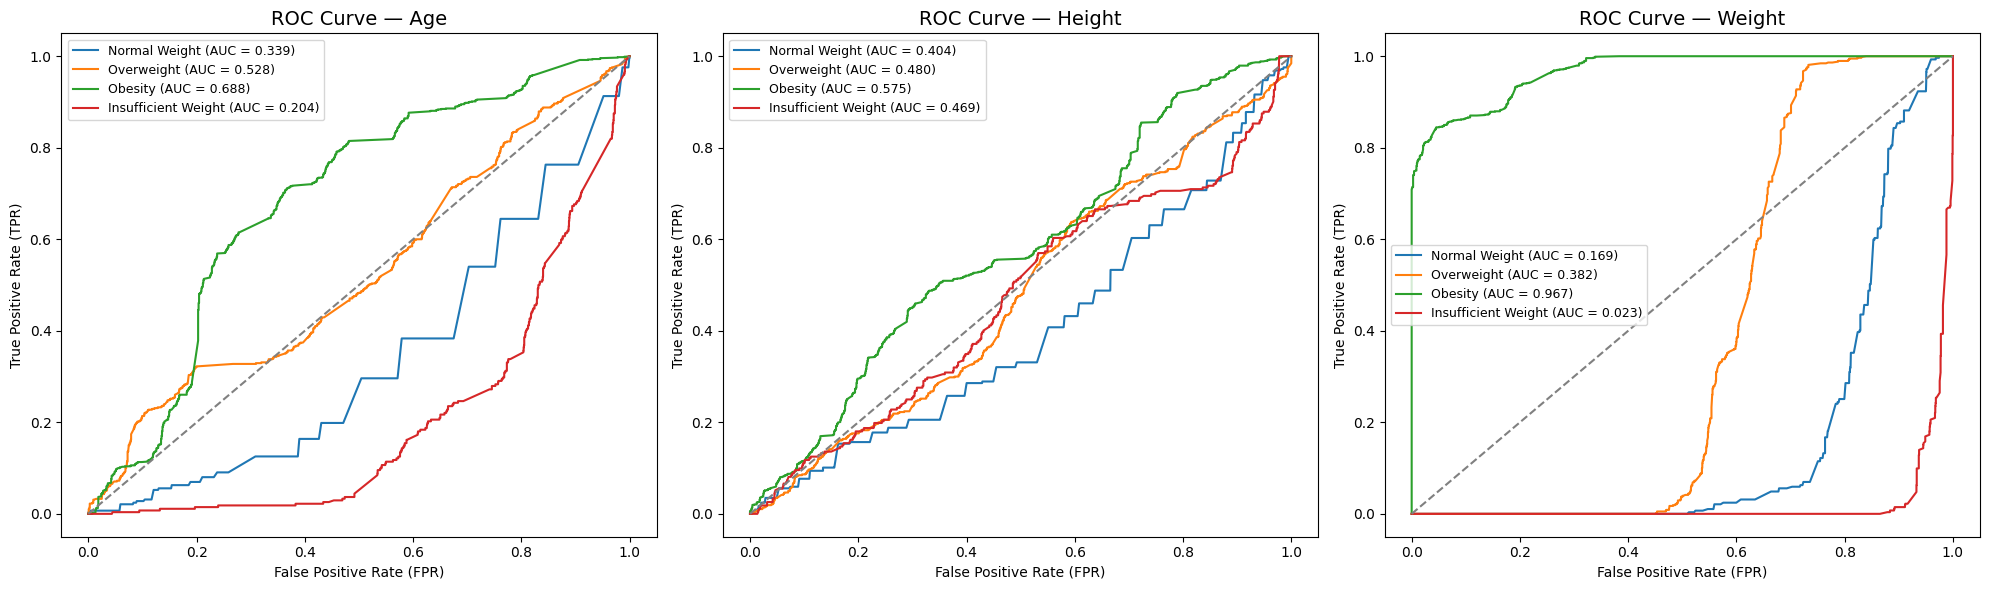

In [29]:
# Figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, feat in zip(axes, continuous_features):

    X = data[feat].values

    for lvl in levels:
        # One-vs-rest labels
        y = (data["NObeyesdad"] == lvl).astype(int).values

        # Compute ROC
        fpr, tpr, _ = roc_curve(y, X)

        # Compute AUC
        auc = roc_auc_score(y, X)

        # Plot
        ax.plot(fpr, tpr, label=f"{lvl} (AUC = {auc:.3f})")

    ax.plot([0, 1], [0, 1], "--", color="gray")  # diagonal line
    ax.set_title(f"ROC Curve — {feat}", fontsize=14)
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## KS/DeLong and FDR on p-values

(generado con ayuda de chat)

### KS test for separation meaning

In [47]:
ks_results = []

for feat in continuous_features:
  X = data[feat].values
  for lvl in levels:
    y = (data["NObeyesdad"] == lvl).astype(int).values

    # KS test comparing positive vs negative class
    pos = X[y == 1]
    neg = X[y == 0]

    ks_stat, ks_p = ks_2samp(pos, neg)

    ks_results.append({
        "Feature": feat,
        "Target Level": lvl,
        "KS Statistic": ks_stat,
        "KS p-value": ks_p
    })

df_ks = pd.DataFrame(ks_results)
df_ks

,Feature,Target Level,KS Statistic,KS p-value
0,Age,Normal Weight,0.291615,3.862624e-19
1,Age,Overweight,0.122544,5.743854e-06
2,Age,Obesity,0.344068,1.402693e-55
3,Age,Insufficient Weight,0.473845,4.736574e-49
4,Height,Normal Weight,0.199143,4.308240e-09
5,Height,Overweight,0.088823,2.423874e-03
6,Height,Obesity,0.156662,1.046561e-11
7,Height,Insufficient Weight,0.144378,8.914262e-05
8,Weight,Normal Weight,0.666059,7.248112e-107
9,Weight,Overweight,0.469398,1.490914e-84


### Apply FDR to p-values of KS

In [48]:
df_ks["KS p-adj (FDR)"] = multipletests(df_ks["KS p-value"], method="fdr_bh")[1]
df_ks["Significant (FDR<0.05)"] = df_ks["KS p-adj (FDR)"] < 0.05

df_ks

,Feature,Target Level,KS Statistic,KS p-value,KS p-adj (FDR),Significant (FDR<0.05)
0,Age,Normal Weight,0.291615,3.862624e-19,6.621642e-19,True
1,Age,Overweight,0.122544,5.743854e-06,6.892625e-06,True
2,Age,Obesity,0.344068,1.402693e-55,3.366462e-55,True
3,Age,Insufficient Weight,0.473845,4.736574e-49,9.473148e-49,True
4,Height,Normal Weight,0.199143,4.308240e-09,5.744320e-09,True
5,Height,Overweight,0.088823,2.423874e-03,2.423874e-03,True
6,Height,Obesity,0.156662,1.046561e-11,1.569841e-11,True
7,Height,Insufficient Weight,0.144378,8.914262e-05,9.724650e-05,True
8,Weight,Normal Weight,0.666059,7.248112e-107,2.899245e-106,True
9,Weight,Overweight,0.469398,1.490914e-84,4.472743e-84,True


## c. Report the observed Type I error (false positive rate) for each level.


In [30]:
type1_list = []

for _, row in df_cm.iterrows():
    TN = row["TN"]
    FP = row["FP"]

    # evitar división por cero
    if TN + FP == 0:
        FPR = np.nan
    else:
        FPR = FP / (FP + TN)

    type1_list.append({
        "Feature": row["Feature"],
        "Target Level": row["Target Level"],
        "Threshold": row["Threshold"],
        "Type I Error (FPR)": FPR
    })

df_type1 = pd.DataFrame(type1_list)
df_type1

,Feature,Target Level,Threshold,Type I Error (FPR)
0,Age,Normal Weight,61.000000,0.000000
1,Age,Overweight,26.047077,0.199869
2,Age,Obesity,22.200779,0.367867
3,Age,Insufficient Weight,16.000000,0.998912
4,Height,Normal Weight,1.870000,0.028509
5,Height,Overweight,1.672101,0.593730
6,Height,Obesity,1.732383,0.330992
7,Height,Insufficient Weight,1.686936,0.560087
8,Weight,Normal Weight,45.000000,0.959430
9,Weight,Overweight,60.117993,0.732854


## d. Report the observed Type II error (false negative rate) for each level.


In [31]:
type2_list = []

for _, row in df_cm.iterrows():
  FN = row["FN"]
  TP = row["TP"]

  # evitar división por cero
  if FN + TP == 0:
    FNR = np.nan
  else:
    FNR = FN / (FN + TP)

  type2_list.append({
    "Feature": row["Feature"],
    "Target Level": row["Target Level"],
    "Threshold": row["Threshold"],
    "Type II Error (FNR)": FNR
  })

df_type2 = pd.DataFrame(type2_list)
df_type2

,Feature,Target Level,Threshold,Type II Error (FNR)
0,Age,Normal Weight,61.000000,0.996516
1,Age,Overweight,26.047077,0.677586
2,Age,Obesity,22.200779,0.288066
3,Age,Insufficient Weight,16.000000,0.000000
4,Height,Normal Weight,1.870000,0.965157
5,Height,Overweight,1.672101,0.362069
6,Height,Obesity,1.732383,0.512346
7,Height,Insufficient Weight,1.686936,0.397059
8,Weight,Normal Weight,45.000000,0.006969
9,Weight,Overweight,60.117993,0.018966


In [32]:
df_errors = pd.merge(df_type1, df_type2, on=['Feature', 'Target Level', 'Threshold'], how='inner')
df_errors

,Feature,Target Level,Threshold,Type I Error (FPR),Type II Error (FNR)
0,Age,Normal Weight,61.000000,0.000000,0.996516
1,Age,Overweight,26.047077,0.199869,0.677586
2,Age,Obesity,22.200779,0.367867,0.288066
3,Age,Insufficient Weight,16.000000,0.998912,0.000000
4,Height,Normal Weight,1.870000,0.028509,0.965157
5,Height,Overweight,1.672101,0.593730,0.362069
6,Height,Obesity,1.732383,0.330992,0.512346
7,Height,Insufficient Weight,1.686936,0.560087,0.397059
8,Weight,Normal Weight,45.000000,0.959430,0.006969
9,Weight,Overweight,60.117993,0.732854,0.018966


## e. Determine which feature has the highest statistical power (1 - Type II error) across levels.


In [33]:
# Add a new column Power = 1 - FNR
df_type2["Power"] = 1 - df_type2["Type II Error (FNR)"]

# Compute average power per feature across all obesity levels
df_power_summary = (
  df_type2.groupby("Feature")["Power"]
        .mean()
        .reset_index()
        .sort_values("Power", ascending=False)
)

df_power_summary

,Feature,Power
2,Weight,0.704679
0,Age,0.509458
1,Height,0.440842


In [34]:
# Identificar la feature con mayor poder
best_feature = df_power_summary.iloc[0]
best_feature

,2
Feature,Weight
Power,0.704679


## f. Determine which feature has the lowest observed alpha (Type I error) across levels.



In [35]:
# Compute mean alpha per feature
df_alpha_summary = (
  df_type1.groupby("Feature")["Type I Error (FPR)"]
        .mean()
        .reset_index()
        .sort_values("Type I Error (FPR)", ascending=True)
)

df_alpha_summary

,Feature,Type I Error (FPR)
1,Height,0.378329
0,Age,0.391662
2,Weight,0.434485


In [36]:
best_alpha_feature = df_alpha_summary.iloc[0]
best_alpha_feature

,1
Feature,Height
Type I Error (FPR),0.378329


# 7. Diagnostic Metrics (Accuracy, Sensitivity, Specificity, Kappa)

## Computed diagnostic metrics (accuracy, sensitivity, specificity, Cohen’s kappa or weighted kappa) for key categorical/ordinal variables in a one-vs-rest framework.

In [39]:
results_diag = []

for feat in ["CAEC", "FAVC", "family_history_with_overweight"]:
  X = data[feat].astype(str)
  for lvl in levels:
    y = (data[target] == lvl).astype(int)

    # Clasificación simple por categoría dominante
    pred = (X == X.mode()[0]).astype(int)  # baseline classifier

    acc = accuracy_score(y, pred)
    sens = recall_score(y, pred)
    spec = recall_score(1-y, 1-pred)
    kappa = cohen_kappa_score(y, pred)

    results_diag.append({
        "Feature": feat,
        "Level": lvl,
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "Kappa": kappa
    })

diag_df = pd.DataFrame(results_diag)
diag_df

,Feature,Level,Accuracy,Sensitivity,Specificity,Kappa
0,CAEC,Normal Weight,0.178588,0.554007,0.119518,-0.102997
1,CAEC,Overweight,0.368546,0.872414,0.177662,0.030636
2,CAEC,Obesity,0.607295,0.981481,0.287972,0.254247
3,CAEC,Insufficient Weight,0.173378,0.536765,0.119630,-0.102920
4,FAVC,Normal Weight,0.177167,0.724739,0.091009,-0.055531
5,FAVC,Overweight,0.299858,0.834483,0.097322,-0.040385
6,FAVC,Obesity,0.558503,0.980453,0.198420,0.167573
7,FAVC,Insufficient Weight,0.196589,0.812500,0.105492,-0.023453
8,family_history_with_overweight,Normal Weight,0.193273,0.540070,0.138706,-0.103204
9,family_history_with_overweight,Overweight,0.363335,0.829310,0.186806,0.009987
